# Fake News Classifier

In [137]:
# Import packages
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
import re 

%matplotlib inline

In [3]:
file_path = %pwd

In [5]:
files = []
for dirname, _, filenames in os.walk(file_path+"\data"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            files.append(os.path.join(dirname, filename))

C:\Users\Loren\fake news\data\Fake.csv\Fake.csv
C:\Users\Loren\fake news\data\True.csv\True.csv


In [31]:
fake = pd.read_csv(files[0])
true = pd.read_csv(files[1])

In [32]:
print(fake.shape)
fake.head()

(23481, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [33]:
print(true.shape)
true.head()

(21417, 4)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [36]:
true['label'] = 1
fake['label'] = 0

In [37]:
df = pd.concat([true, fake])

In [38]:
df['title_count'] = df['title'].apply(lambda x: len(x.split()))
df['text_count'] = df['text'].apply(lambda x: len(x.split()))

In [39]:
df.head()

,title,text,subject,date,label,title_count,text_count
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,10,749
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,9,624
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,10,457
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,9,376
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,11,852


In [42]:
df.isna().sum()

title          0
text           0
subject        0
date           0
label          0
title_count    0
text_count     0
dtype: int64

In [59]:
df.groupby('label')['text_count'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,23481.0,423.197905,408.388890,0.0,240.0,363.0,506.0,8135.0
1,21417.0,385.640099,274.006204,0.0,148.0,359.0,525.0,5172.0


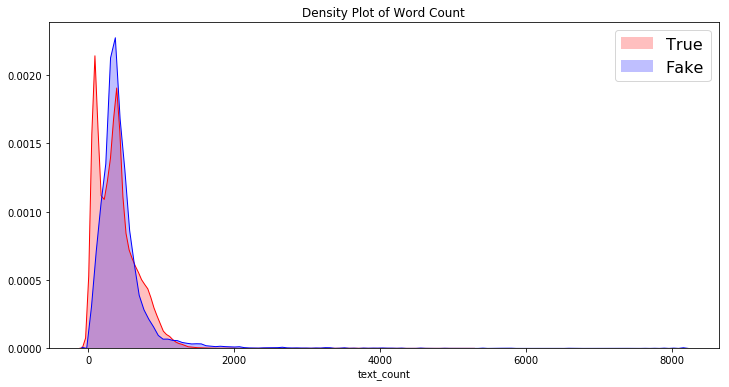

In [54]:
plt.figure(figsize=(12,6))

fake = df.loc[df.label == 0]
true = df.loc[df.label == 1]
sns.distplot(true['text_count'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, color="r")
sns.distplot(fake['text_count'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, color="b")

plt.legend(['True', 'Fake'], prop={'size': 16})
plt.title('Density Plot of Word Count')
plt.show()

In [60]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

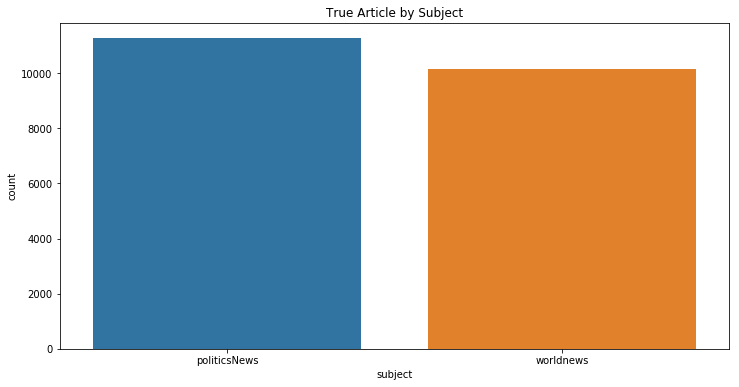

In [65]:
plt.figure(figsize=(12,6))

sns.countplot(x='subject', data=true)

plt.title('True Article by Subject')
plt.show()

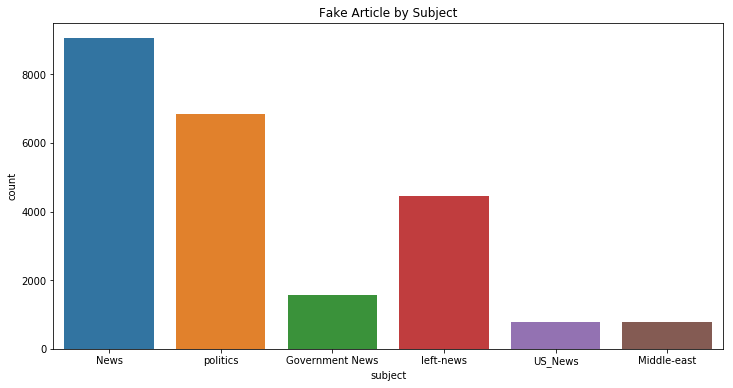

In [66]:
plt.figure(figsize=(12,6))

sns.countplot(x='subject', data=fake)

plt.title('Fake Article by Subject')
plt.show()

In [67]:
#Combine text and titles
df['text'] = df['text'] + " " + df['title']

In [ ]:
stemmer = PorterStemmer()
sw = stopwords.words('English')

In [126]:
# Create text preprocessing function
def text_cleaner(text):
    # remove punctuation
    text = re.sub(r'[^\w\s]','',text) 
    # stem words
    word_list = []
    for i in text.split():
        if i.strip().lower() not in sw:
            word = stemmer.stem(i.strip())
            word_list.append(word)
    return " ".join(word_list)

In [123]:
df.text = df.text.apply(text_cleaner)

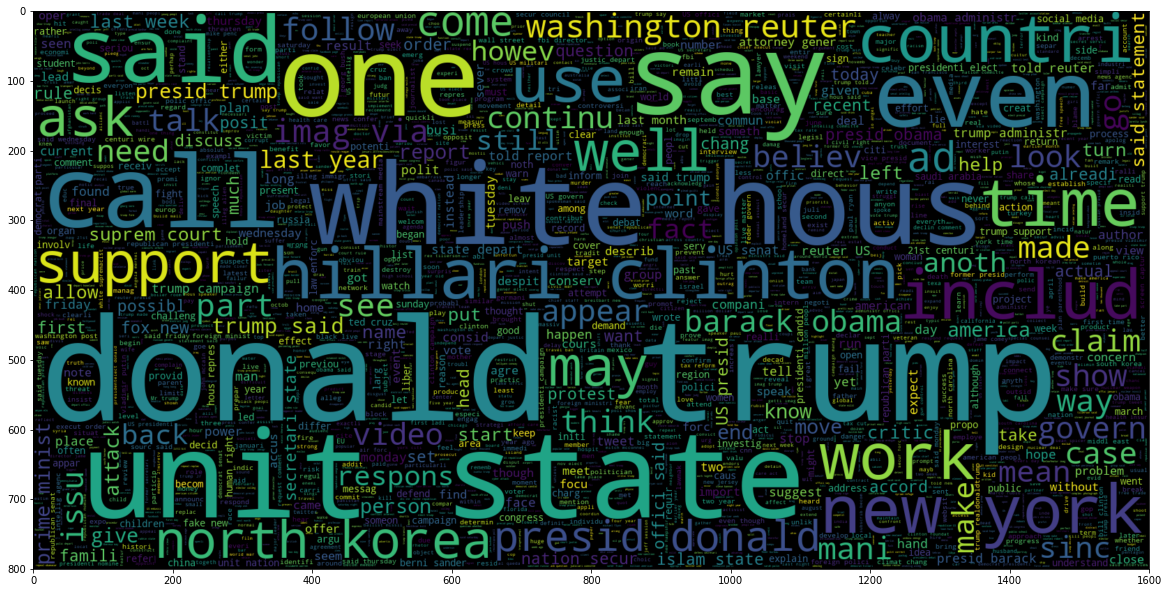

In [130]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2500 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df.text))
plt.imshow(wc , interpolation = 'bilinear')

In [132]:
X = df["text"]
y = df["label"]
x, x_test, y, y_test = train_test_split(X, y,test_size=0.2,train_size=0.8)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25,train_size =0.75)

In [133]:
cv = CountVectorizer(ngram_range=(1,2))

cv_x_train = cv.fit_transform(x_train)

#transformed valid and test set
cv_x_valid =cv.transform(x_valid)
cv_x_test =cv.transform(x_test)


print('cv_train:',cv_x_train.shape)
print('cv_valid:',cv_x_valid.shape)
print('cv_test:',cv_x_test.shape)

cv_train: (26938, 2607916)
cv_valid: (8980, 2607916)
cv_test: (8980, 2607916)


In [135]:
model = Sequential()
model.add(Dense(256, activation = 'relu' , input_dim = cv_x_train.shape[1]))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))

model.add(Dense(units = 1 , activation = 'sigmoid'))

In [136]:
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [138]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               patience=12,
                               factor=0.5,
                               verbose=1)
tensorboard = TensorBoard(log_dir="logs", write_graph=True, write_images=True)
early_stopper = EarlyStopping(monitor='val_loss',
                              mode='auto')
checkpoint = ModelCheckpoint('./models/model.h5')

In [ ]:
training = model.fit(cv_x_train, y_train, 
                        validation_data=(cv_x_valid, y_valid), 
                        validation_steps=8, 
                        epochs=20, verbose=2, 
                        callbacks=[lr_reducer, tensorboard])